## **Setup**

In [ ]:
from collections import OrderedDict
from glob import glob
import math
import os
import pickle
import random
import time
import warnings

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import auc, average_precision_score, precision_recall_curve, roc_auc_score
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

In [ ]:
FILEPATH = '...'
ALL_CAR_DICT_PATH = os.path.join(FILEPATH, 'all_car_dict.npz')
IND_OOD_CAR_DICT_PATH = os.path.join(FILEPATH, 'ind_ood_dict.npz')
EDA_METADATA_HEALTHY_FILE = os.path.join(FILEPATH, 'EDA_Metadata_Healthy.parquet')
EDA_TIMESERIES_HEALTHY_FILE = os.path.join(FILEPATH, 'EDA_Timeseries_Healthy.parquet')
EDA_METADATA_UNHEALTHY_FILE = os.path.join(FILEPATH, 'EDA_Metadata_Unhealthy.parquet')
EDA_TIMESERIES_UNHEALTHY_FILE = os.path.join(FILEPATH, 'EDA_Timeseries_Unhealthy.parquet')
NEURAL_FILEPATH = '...'

In [ ]:
random.seed(777)

In [ ]:
warnings.filterwarnings('ignore', category=UserWarning)

In [ ]:
pd.set_option('display.width', 1440)
pd.set_option('display.max_columns', None)

In [ ]:
!tar -xzkf '/content/drive/My Drive/Projects/EV Batteries/Dataset/battery_dataset3.tar.gz' 2>/dev/null

In [ ]:
if not os.path.exists(ALL_CAR_DICT_PATH + '.npy') or not os.path.exists(IND_OOD_CAR_DICT_PATH + '.npy'):
  print('Generating new files')
  data_path = 'battery_dataset3/data'
  data_pkl_files = glob(data_path + '/*.pkl')

  ind_pkl_files = []
  ood_pkl_files = []
  car_num_list = []

  ood_car_num_list = set()
  ind_car_num_list = set()

  all_car_dict = {}

  for each_path in data_pkl_files:
    this_pkl_file = torch.load(each_path, weights_only=False)
    this_car_number = this_pkl_file[1]['car']
    if this_pkl_file[1]['label'] == '00':
        ind_pkl_files.append(each_path)
        ind_car_num_list.add(this_car_number)
    else:
        ood_pkl_files.append(each_path)
        ood_car_num_list.add(this_car_number)
    car_num_list.append(this_pkl_file[1]['car'])
    if this_car_number not in all_car_dict:
        all_car_dict[this_car_number] = []
        all_car_dict[this_car_number].append(each_path)
    else:
        all_car_dict[this_car_number].append(each_path)

  np.save(ALL_CAR_DICT_PATH, all_car_dict)

  ind_sorted = sorted(ind_car_num_list)
  random.shuffle(ind_sorted)
  ood_sorted = sorted(ood_car_num_list)
  random.shuffle(ood_sorted)
  ind_ood_dict = {}
  ind_ood_dict['ind_sorted'],ind_ood_dict['ood_sorted'] = ind_sorted, ood_sorted
  np.save(IND_OOD_CAR_DICT_PATH, ind_ood_dict)

  print('New files generated')
else:
  print('Files exist')
  all_car_dict = np.load(ALL_CAR_DICT_PATH + '.npy', allow_pickle=True)
  ind_ood_dict = np.load(IND_OOD_CAR_DICT_PATH + '.npy', allow_pickle=True)

Files exist


In [ ]:
TIMESERIES_COLUMNS = [
    'volt',
    'current',
    'soc',
    'max_single_volt',
    'min_single_volt',
    'max_temp',
    'min_temp',
    'timestamp'
]

#**EDA**

In [ ]:
if not os.path.exists(EDA_METADATA_HEALTHY_FILE) or not os.path.exists(EDA_TIMESERIES_HEALTHY_FILE):
  random_ind_id = random.choice(ind_ood_dict[()]['ind_sorted'])
  rii_file_list = all_car_dict[()][random_ind_id]

  rii_files = []
  for each_file in rii_file_list:
    rii_files.append(torch.load(each_file, weights_only=False))

  rii_files = sorted(rii_files, key=lambda x: (x[1]['charge_segment'], x[0][0][7]))

  metadata_df_list = []
  timeseries_dfs_list = []

  for snippet_index, file in enumerate(rii_files):
    snippet, metadata = file

    metadata['snippet_index'] = snippet_index
    metadata_df_list.append(metadata)

    snippet_df = pd.DataFrame(snippet, columns=TIMESERIES_COLUMNS)
    snippet_df['snippet_index'] = snippet_index
    snippet_df['time_step'] = range(len(snippet_df))
    timeseries_dfs_list.append(snippet_df)

  metadata_df = pd.DataFrame(metadata_df_list)
  timeseries_df = pd.concat(timeseries_dfs_list, ignore_index=True)

  metadata_df.to_parquet(EDA_METADATA_HEALTHY_FILE)
  timeseries_df.to_parquet(EDA_TIMESERIES_HEALTHY_FILE)
else:
  metadata_df = pd.read_parquet(EDA_METADATA_HEALTHY_FILE)
  timeseries_df = pd.read_parquet(EDA_TIMESERIES_HEALTHY_FILE)

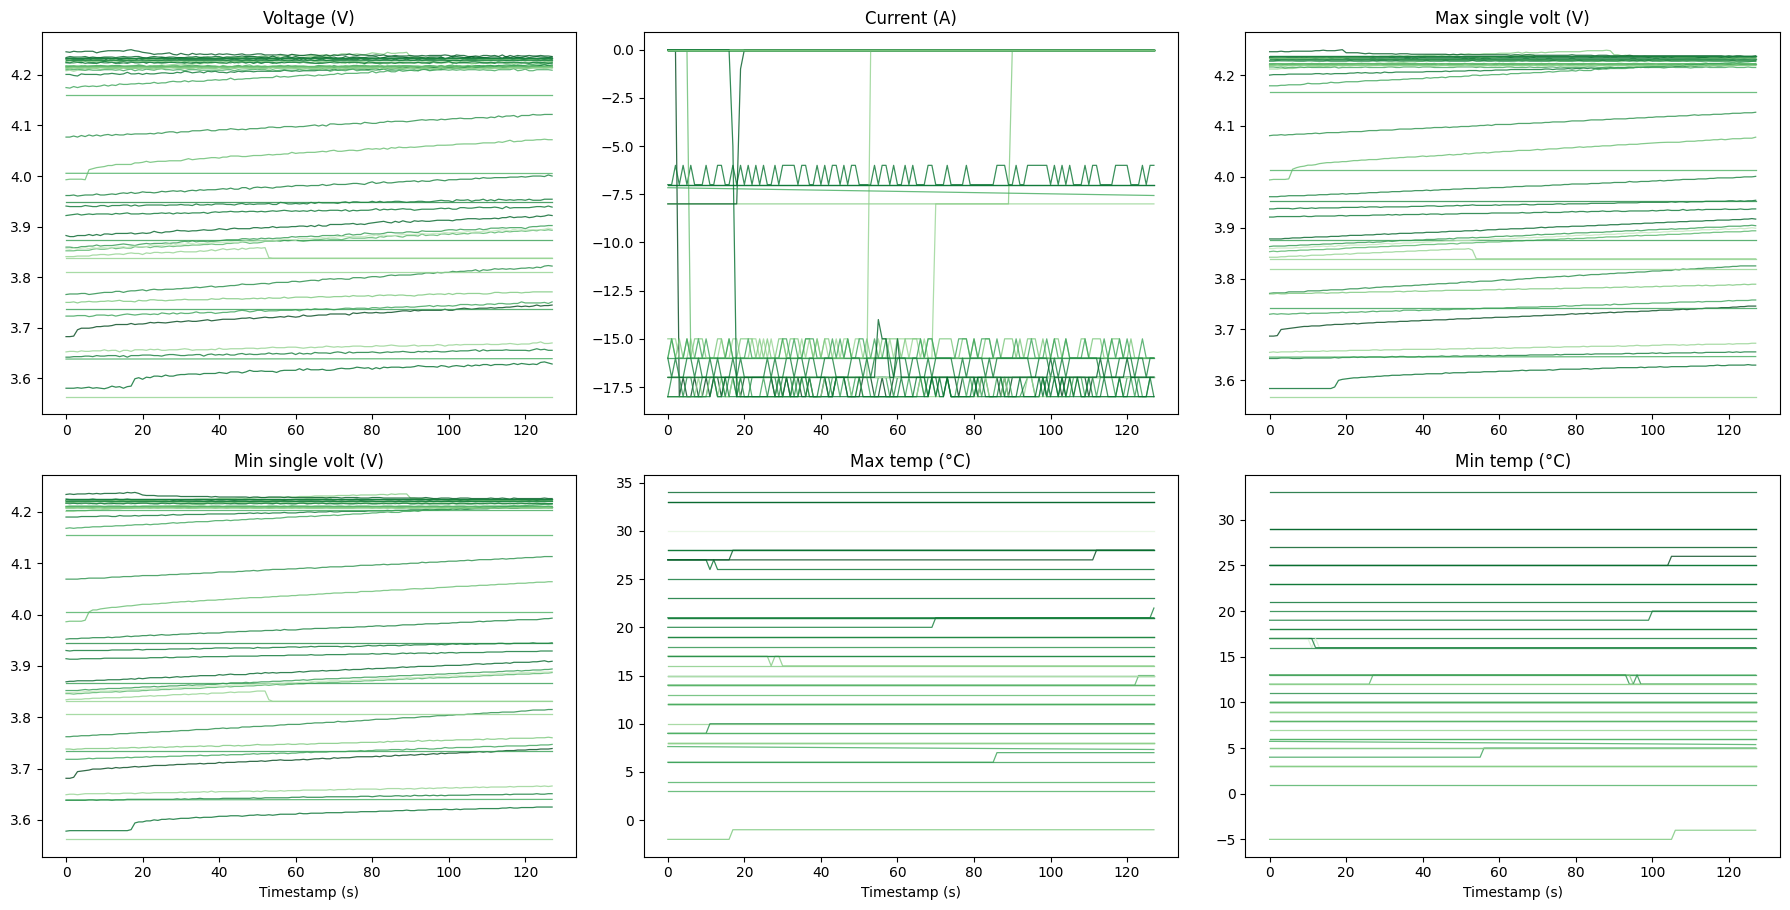

In [ ]:
plot_df = timeseries_df.merge(metadata_df[['snippet_index', 'mileage']], on='snippet_index', how='left')
PLOT_FEATURES = ['volt', 'current', 'max_single_volt', 'min_single_volt', 'max_temp', 'min_temp']
PLOT_TITLES = ['Voltage (V)', 'Current (A)', 'Max single volt (V)', 'Min single volt (V)', 'Max temp (°C)', 'Min temp (°C)']

mileage_norm = mcolors.Normalize(vmin=plot_df['mileage'].min(), vmax=plot_df['mileage'].max())

cmap = plt.get_cmap('Greens_r')

fig, axes = plt.subplots(2, 3, figsize=(18,10))
ax_list = axes.flatten()

all_snippet_ids = plot_df['snippet_index'].unique()
snippet_ids = pd.Series(all_snippet_ids).sample(n=50, random_state=1)
for snippet_id in snippet_ids:
  snippet_df = plot_df[plot_df['snippet_index'] == snippet_id]

  color = cmap(mileage_norm(snippet_df['mileage'].iloc[0]))

  for i, (feature, ax) in enumerate (zip(PLOT_FEATURES, ax_list)):
    ax.plot(snippet_df['time_step'], snippet_df[feature], color=color, alpha=0.8, linewidth=0.9)

for ax, title in zip(ax_list, PLOT_TITLES):
    ax.set_title(title)
    if ax in [axes[1, 0], axes[1, 1], axes[1, 2]]:
        ax.set_xlabel('Timestamp (s)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

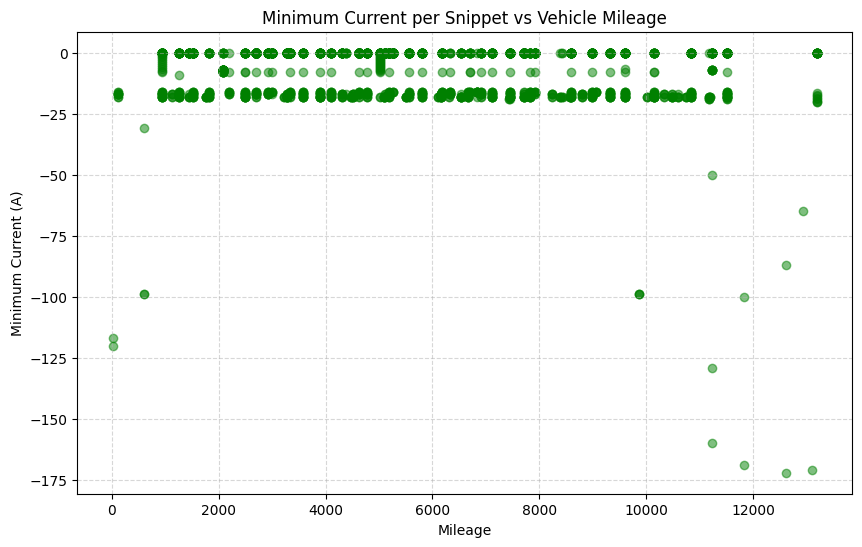

In [ ]:
snippet_min_current = plot_df.groupby('snippet_index')['current'].min()
snippet_min_current_df = snippet_min_current.reset_index()
snippet_min_current_df = snippet_min_current_df.rename(columns={'current': 'min_current'})
plot_data = pd.merge(
    snippet_min_current_df,
    metadata_df[['snippet_index', 'mileage']],
    on='snippet_index',
    how='left'
)
plt.figure(figsize=(10, 6))

plt.scatter(
    plot_data['mileage'],
    plot_data['min_current'],
    alpha=0.5,
    color='green'
)

plt.title('Minimum Current per Snippet vs Vehicle Mileage')
plt.xlabel('Mileage')
plt.ylabel('Minimum Current (A)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [ ]:
FAST_CHARGE_THRESHOLD = -50.0
CURRENT_COL_INDEX = TIMESERIES_COLUMNS.index('current')

In [ ]:
healthy_car_ids = ind_ood_dict[()]['ind_sorted']

car_charge_stats = []

for car_id in healthy_car_ids:

    fast_charge_count = 0
    slow_charge_count = 0

    snippet_files = all_car_dict[()].get(car_id, [])

    for file_path in snippet_files:
        snippet, metadata = torch.load(file_path, weights_only=False)

        current_column = snippet[:, CURRENT_COL_INDEX]

        min_current = np.min(current_column).item()

        if min_current < FAST_CHARGE_THRESHOLD:
            fast_charge_count += 1
        else:
            slow_charge_count += 1

    total_snippets = fast_charge_count + slow_charge_count
    car_charge_stats.append({
        'car_id': car_id,
        'fast_charge_snippets': fast_charge_count,
        'slow_charge_snippets': slow_charge_count,
        'total_snippets': total_snippets,
        'fast_charge_ratio': fast_charge_count / total_snippets
    })

stats_df = pd.DataFrame(car_charge_stats)

print('\nStats')
print(stats_df.head())

print('\nSummary')
print(stats_df.describe())

print(f'\nAverage fast charge ratio: {stats_df['fast_charge_ratio'].mean():.2f}')


Stats
   car_id  fast_charge_snippets  slow_charge_snippets  total_snippets  fast_charge_ratio
0     543                   143                    97             240           0.595833
1     511                   819                  3118            3937           0.208026
2     522                    32                   125             157           0.203822
3     527                   203                  5440            5643           0.035974
4     542                    92                   264             356           0.258427

Summary
           car_id  fast_charge_snippets  slow_charge_snippets  total_snippets  fast_charge_ratio
count   33.000000             33.000000             33.000000       33.000000          33.000000
mean   526.939394            166.878788           2174.818182     2341.696970           0.241092
std     13.946190            200.097751           2864.691480     2851.569814           0.293435
min    503.000000              0.000000             24.000000 

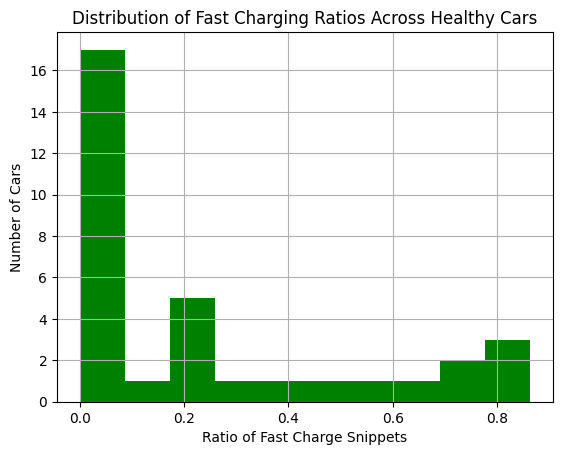

In [ ]:
stats_df['fast_charge_ratio'].hist(bins=10, color='green')
plt.title('Distribution of Fast Charging Ratios Across Healthy Cars')
plt.xlabel('Ratio of Fast Charge Snippets')
plt.ylabel('Number of Cars')
plt.show()

In [ ]:
if not os.path.exists(EDA_METADATA_UNHEALTHY_FILE) or not os.path.exists(EDA_TIMESERIES_UNHEALTHY_FILE):
  random_ind_id = random.choice(ind_ood_dict[()]['ood_sorted'])
  rii_file_list = all_car_dict[()][random_ind_id]

  rii_files = []
  for each_file in rii_file_list:
    rii_files.append(torch.load(each_file, weights_only=False))

  rii_files = sorted(rii_files, key=lambda x: (x[1]['charge_segment'], x[0][0][7]))

  metadata_df_list = []
  timeseries_dfs_list = []

  for snippet_index, file in enumerate(rii_files):
    snippet, metadata = file

    metadata['snippet_index'] = snippet_index
    metadata_df_list.append(metadata)

    snippet_df = pd.DataFrame(snippet, columns=TIMESERIES_COLUMNS)
    snippet_df['snippet_index'] = snippet_index
    snippet_df['time_step'] = range(len(snippet_df))
    timeseries_dfs_list.append(snippet_df)

  metadata_df = pd.DataFrame(metadata_df_list)
  timeseries_df = pd.concat(timeseries_dfs_list, ignore_index=True)

  metadata_df.to_parquet(EDA_METADATA_UNHEALTHY_FILE)
  timeseries_df.to_parquet(EDA_TIMESERIES_UNHEALTHY_FILE)
else:
  metadata_df = pd.read_parquet(EDA_METADATA_UNHEALTHY_FILE)
  timeseries_df = pd.read_parquet(EDA_TIMESERIES_UNHEALTHY_FILE)

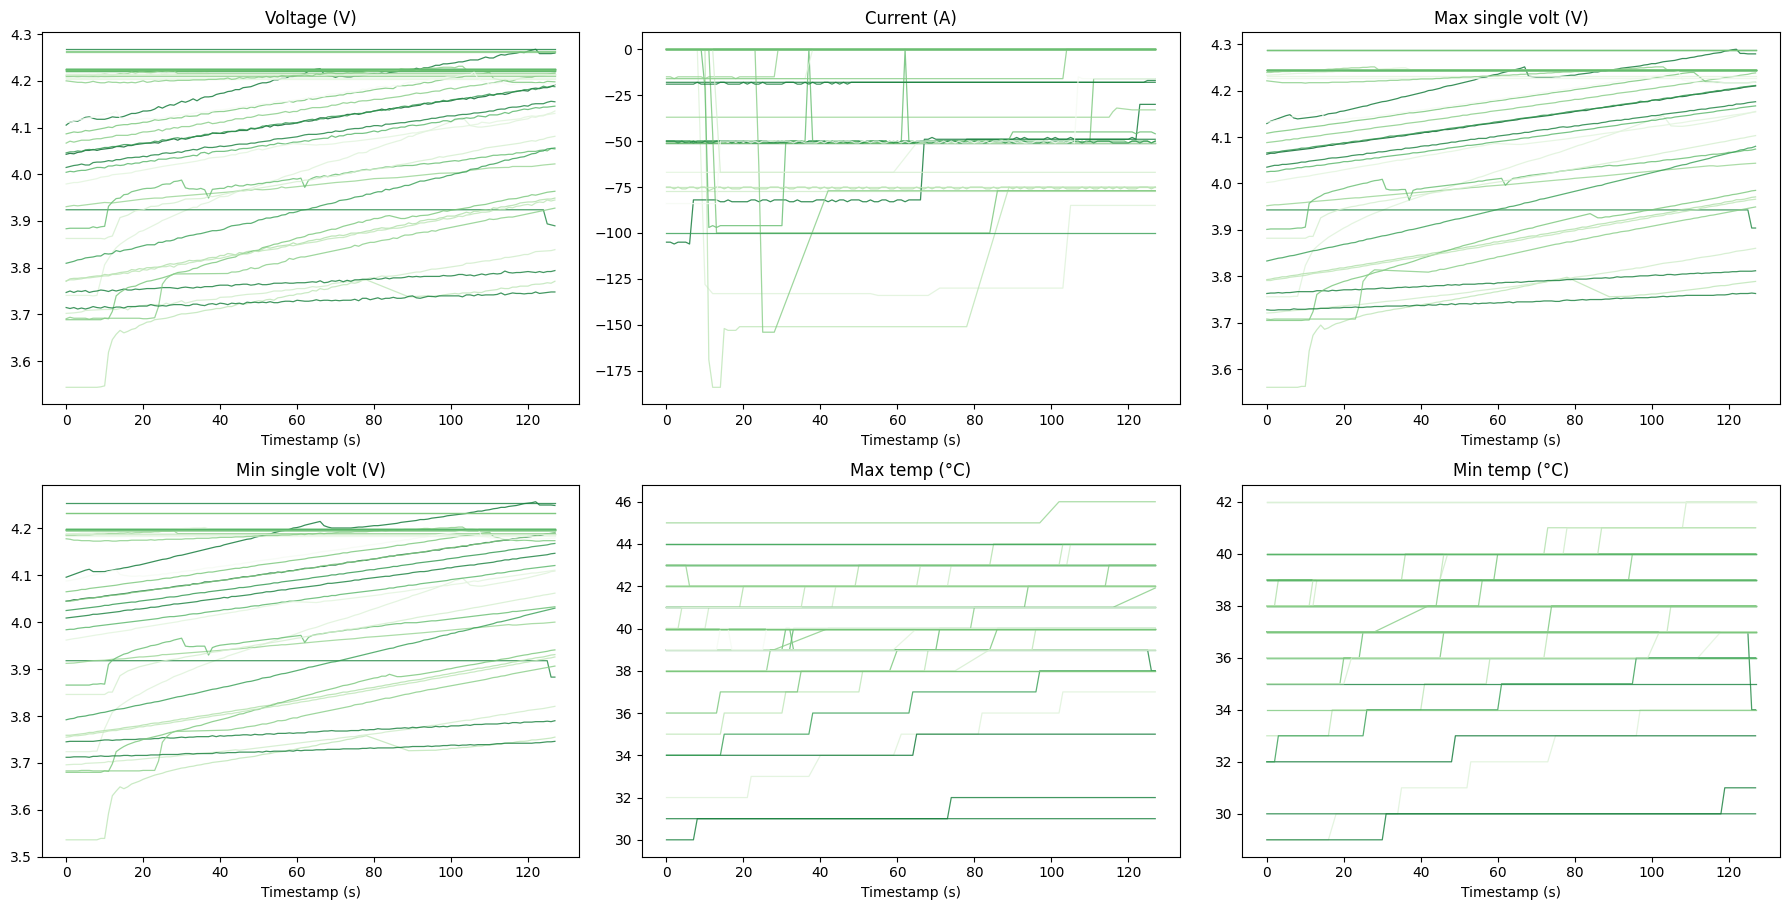

In [ ]:
plot_df = timeseries_df.merge(metadata_df[['snippet_index', 'mileage']], on='snippet_index', how='left')
PLOT_FEATURES = ['volt', 'current', 'max_single_volt', 'min_single_volt', 'max_temp', 'min_temp']
PLOT_TITLES = ['Voltage (V)', 'Current (A)', 'Max single volt (V)', 'Min single volt (V)', 'Max temp (°C)', 'Min temp (°C)']

mileage_norm = mcolors.Normalize(vmin=plot_df['mileage'].min(), vmax=plot_df['mileage'].max())

cmap = plt.get_cmap('Greens_r')

fig, axes = plt.subplots(2, 3, figsize=(18,10))
ax_list = axes.flatten()

all_snippet_ids = plot_df['snippet_index'].unique()
snippet_ids = pd.Series(all_snippet_ids).sample(n=50, random_state=1)
for snippet_id in snippet_ids:
  snippet_df = plot_df[plot_df['snippet_index'] == snippet_id]

  color = cmap(mileage_norm(snippet_df['mileage'].iloc[0]))

  for i, (feature, ax) in enumerate (zip(PLOT_FEATURES, ax_list)):
    ax.plot(snippet_df['time_step'], snippet_df[feature], color=color, alpha=0.8, linewidth=0.9)

for ax, title in zip(ax_list, PLOT_TITLES):
    ax.set_title(title)
    ax.set_xlabel('Timestamp (s)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

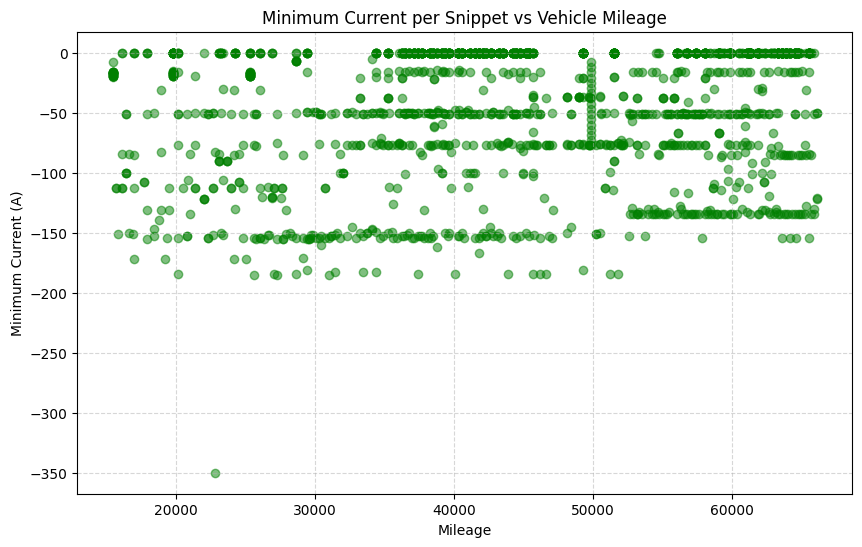

In [ ]:
snippet_min_current = plot_df.groupby('snippet_index')['current'].min()
snippet_min_current_df = snippet_min_current.reset_index()
snippet_min_current_df = snippet_min_current_df.rename(columns={'current': 'min_current'})
plot_data = pd.merge(
    snippet_min_current_df,
    metadata_df[['snippet_index', 'mileage']],
    on='snippet_index',
    how='left'
)
plt.figure(figsize=(10, 6))

plt.scatter(
    plot_data['mileage'],
    plot_data['min_current'],
    alpha=0.5,
    color='green'
)

plt.title('Minimum Current per Snippet vs Vehicle Mileage')
plt.xlabel('Mileage')
plt.ylabel('Minimum Current (A)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [ ]:
unhealthy_car_ids = ind_ood_dict[()]['ood_sorted']

car_charge_stats = []

for car_id in unhealthy_car_ids:

    fast_charge_count = 0
    slow_charge_count = 0

    snippet_files = all_car_dict[()].get(car_id, [])

    for file_path in snippet_files:
        snippet, metadata = torch.load(file_path, weights_only=False)

        current_column = snippet[:, CURRENT_COL_INDEX]

        min_current = np.min(current_column).item()

        if min_current < FAST_CHARGE_THRESHOLD:
            fast_charge_count += 1
        else:
            slow_charge_count += 1

    total_snippets = fast_charge_count + slow_charge_count
    car_charge_stats.append({
        'car_id': car_id,
        'fast_charge_snippets': fast_charge_count,
        'slow_charge_snippets': slow_charge_count,
        'total_snippets': total_snippets,
        'fast_charge_ratio': fast_charge_count / total_snippets
    })

stats_df = pd.DataFrame(car_charge_stats)

print('\nStats')
print(stats_df.head())

print('\nSummary')
print(stats_df.describe())

print(f'\nAverage fast charge ratio: {stats_df['fast_charge_ratio'].mean():.2f}')


Stats
   car_id  fast_charge_snippets  slow_charge_snippets  total_snippets  fast_charge_ratio
0     532                   683                  1590            2273           0.300484
1     518                  1288                   352            1640           0.785366
2     515                   200                  2202            2402           0.083264
3     541                     1                  3078            3079           0.000325
4     521                    54                 15295           15349           0.003518

Summary
          car_id  fast_charge_snippets  slow_charge_snippets  total_snippets  fast_charge_ratio
count   16.00000             16.000000             16.000000       16.000000          16.000000
mean   518.18750            515.500000           5675.187500     6190.687500           0.231204
std     13.98675            564.208118           6468.920118     6275.660897           0.262891
min    500.00000              1.000000            175.000000      

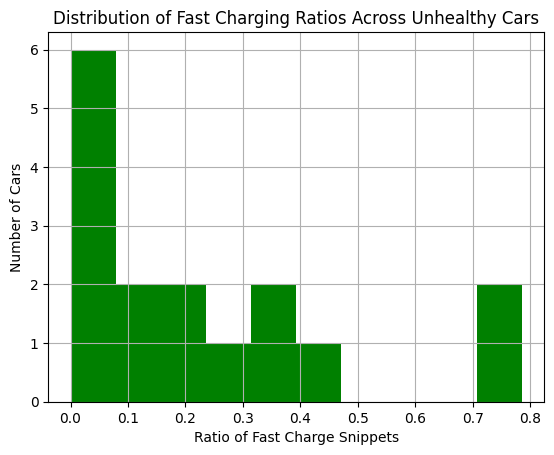

In [ ]:
stats_df['fast_charge_ratio'].hist(bins=10, color='green')
plt.title('Distribution of Fast Charging Ratios Across Unhealthy Cars')
plt.xlabel('Ratio of Fast Charge Snippets')
plt.ylabel('Number of Cars')
plt.show()

#Model

In [ ]:
EPOCHS = 10
LEARNING_RATE = 1e-3
NLL_WEIGHT = 1.0
LABEL_WEIGHT = 1.0

ANNEAL_FUNCTION = 'logistic'
K_VAL = 0.0025
X0_VAL = 2500
ANNEAL0 = 0.5


BATCH_SIZE = 64
NUM_WORKERS = 2
VARIABLE_LENGTH = True
FOLD_NUM = 0

COLUMNS = [    'volt', 'current', 'soc', 'max_single_volt', 'min_single_volt',
    'max_temp', 'min_temp', 'timestamp']

In [ ]:
def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return x

def to_tensor(input_embedding):
    return to_var(torch.from_numpy(np.array(input_embedding)))

def to_array(input_embedding):
    return input_embedding.cpu().numpy()

def pad_tensor(v, max_len):
    pad_size = max_len - v.shape[0]
    if pad_size <= 0:
        return v
    padding = torch.zeros(pad_size, v.shape[1], dtype=v.dtype)
    return torch.cat([v, padding], dim=0)

def collate(batch_data):
    batch_data.sort(key=lambda xi: len(xi[0]), reverse=True)
    seq_lengths = [len(xi[0]) for xi in batch_data]
    max_len = max(seq_lengths)

    sent_seq = [torch.FloatTensor(v[0]) for v in batch_data]
    metadata_list = [xi[1] for xi in batch_data]
    metadata = OrderedDict([('label', []), ('car', []), ('charge_segment', []), ('mileage', []), ('timestamp', [])])
    for i in range(len(metadata_list)):
        for key, value in metadata_list[i].items():
            if key in metadata:
                metadata[key].append(value)

    padded_sent_seq = torch.stack([pad_tensor(v, max_len) for v in sent_seq], dim=0)
    metadata['seq_lengths'] = seq_lengths
    return padded_sent_seq, metadata

def kl_anneal_function(step: int) -> float:
    if ANNEAL_FUNCTION == 'logistic':
        return ANNEAL0 * float(1 / (1 + np.exp(-K_VAL * (step - X0_VAL))))
    elif ANNEAL_FUNCTION == 'linear':
        return ANNEAL0 * min(1, step / X0_VAL)
    else:
        return ANNEAL0

In [ ]:
class Dataset:
    def __init__(self, all_car_dict_path, ind_ood_car_dict_path,train=True, fold_num=0):
        ind_ood_car_dict = np.load(ind_ood_car_dict_path, allow_pickle=True).item()
        self.ind_car_num_list = ind_ood_car_dict['ind_sorted']
        self.ood_car_num_list = ind_ood_car_dict['ood_sorted']
        self.all_car_dict = np.load(all_car_dict_path, allow_pickle=True).item()

        if train:
            car_number = self.ind_car_num_list[
                         :int(fold_num * len(self.ind_car_num_list) / 5)] + self.ind_car_num_list[
                                                                            int((fold_num + 1) * len(
                                                                                self.ind_car_num_list) / 5):]
        else:
            car_number = self.ind_car_num_list[
                         int(fold_num * len(self.ind_car_num_list) / 5):int(
                             (fold_num + 1) * len(self.ind_car_num_list) / 5)] + self.ood_car_num_list

        self.battery_dataset = []

        print('Cars: ', car_number)

        for each_num in car_number:
            for each_pkl in self.all_car_dict[each_num]:
                train1 = torch.load(each_pkl, weights_only=False)
                self.battery_dataset.append(train1)

    def __len__(self):
        return len(self.battery_dataset)

    def __getitem__(self, idx):
        file = self.battery_dataset[idx]
        return file

In [ ]:
class Task:
    def __init__(self, columns, encoder_dimension=122, decoder_dimension=122,
                 output_dimension=122, task_name='ev'):
        self.encoder_dimension = encoder_dimension
        self.decoder_dimension = decoder_dimension
        self.output_dimension = output_dimension
        self.task_name = task_name
        self.columns = columns
        self.encoder = []
        self.decoder = []
        self.target = []
        eval(self.task_name.capitalize() + 'Task.set_params')(self)
        eval(self.task_name.capitalize() + 'Task.get_task_idx')(self, columns)

    def encoder_filter(self, input_embedding):
        return eval(self.task_name.capitalize() + 'Task.task_encoder')(self, input_embedding, self.columns)

    def decoder_filter(self, input_embedding):
        self.decoder = self.encoder[:self.decoder_dimension]
        return to_tensor(to_array(input_embedding)[:, :, self.decoder])

    def target_filter(self, input_embedding):
        self.target = self.encoder[self.decoder_dimension:]
        return to_tensor(to_array(input_embedding)[:, :, self.target])

    def task_encoder(self, input_embedding, columns):
        return to_tensor(to_array(input_embedding)[:, :, self.encoder])


class EvTask(Task):
    def set_params(self):
        self.encoder_dimension = 6
        self.decoder_dimension = 2
        self.output_dimension = 4

    def get_task_idx(self, columns):
        self.encoder = np.array(
            [columns.index('soc'), columns.index('current'),
             columns.index('max_temp'), columns.index('max_single_volt'),
             columns.index('min_single_volt'), columns.index('volt')]).astype(int)
        return self.encoder

In [ ]:
class Normalizer:
    def __init__(self, dfs=None, variable_length=False):
        self.max_norm = 0
        self.min_norm = 0
        self.std = 0
        self.mean = 0
        res = []
        if dfs is not None:
            if variable_length:
                norm_length = min([len(df) for df in dfs])
                dfs = [df[0:norm_length] for df in dfs]
            res.extend(dfs)
            res = np.array(res)
            self.compute_min_max(res)
        else:
            raise Exception('df list not specified')

    def compute_min_max(self, res):
        column_max_all = np.max(res, axis=1)
        column_min_all = np.min(res, axis=1)
        column_std_all = np.std(res, axis=1)
        column_mean_all = np.mean(res, axis=1)
        self.max_norm = np.max(column_max_all, axis=0)
        self.min_norm = np.min(column_min_all, axis=0)
        self.std = np.mean(column_std_all, axis=0)
        self.mean = np.mean(column_mean_all, axis=0)

    def norm_func(self, df):
        df_norm = df.copy()
        df_norm = (df_norm - self.mean) / np.maximum(np.maximum(1e-4, self.std), 0.1 * (self.max_norm - self.min_norm))
        return df_norm

class PreprocessNormalizer:
    def __init__(self, dataset, normalizer_fn=None):
        self.dataset = dataset
        self.normalizer_fn = normalizer_fn

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        df, metadata = self.dataset[idx][0], self.dataset[idx][1]
        if self.normalizer_fn is not None:
            df = self.normalizer_fn(df)
        return df, metadata

In [ ]:
data_pre = Dataset(train=True, fold_num=FOLD_NUM, all_car_dict_path=ALL_CAR_DICT_PATH+'.npy', ind_ood_car_dict_path=IND_OOD_CAR_DICT_PATH+'.npy')

print('Calculating normalization stats...')
normalizer = Normalizer(dfs=[data_pre[i][0] for i in range(min(200, len(data_pre)))],
                          variable_length=VARIABLE_LENGTH)
print('Normalization stats calculated.')

train_dataset = PreprocessNormalizer(data_pre, normalizer_fn=normalizer.norm_func)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    drop_last=False,
    pin_memory=torch.cuda.is_available(),
    collate_fn=collate if VARIABLE_LENGTH else None
)

print(f'\nDataLoader initialized with {len(train_loader)} batches.')

Cars:  [531, 526, 519, 525, 530, 536, 517, 546, 538, 512, 540, 503, 548, 524, 529, 506, 528, 535, 508, 547, 509, 544, 549, 516, 537, 505, 513]
Calculating normalization stats...
Normalization stats calculated.

DataLoader initialized with 946 batches.


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        pe = pe.permute(1, 0, 2)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [ ]:
class TransformerDyAD(nn.Module):
    def __init__(self, hidden_size, latent_size, nhead, dim_feedforward, num_layers,
                 variable_length, encoder_embedding_size, decoder_embedding_size,
                 output_embedding_size, dropout=0.1, **params):
        super().__init__()
        self.latent_size = latent_size
        self.hidden_size = hidden_size
        self.variable_length = variable_length

        self.encoder_input_proj = nn.Sequential(
            nn.Linear(encoder_embedding_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )
        self.decoder_input_proj = nn.Linear(decoder_embedding_size, hidden_size)

        self.pos_encoder = PositionalEncoding(hidden_size, dropout)

        self.hidden2mean = nn.Linear(hidden_size, latent_size)
        self.hidden2log_v = nn.Linear(hidden_size, latent_size)

        self.mean2latent = nn.Sequential(
            nn.Linear(latent_size, int(hidden_size / 2)),
            nn.ReLU(),
            nn.Linear(int(hidden_size / 2), 1)
        )
        self.latent2memory = nn.Linear(latent_size, hidden_size)

        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=nhead,
                                                 dim_feedforward=dim_feedforward,
                                                 dropout=dropout, batch_first=True)
        self.encoder_transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        decoder_layer = nn.TransformerDecoderLayer(d_model=hidden_size, nhead=nhead,
                                                 dim_feedforward=dim_feedforward,
                                                 dropout=dropout, batch_first=True)
        self.decoder_transformer = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.outputs2embedding = nn.Linear(hidden_size, output_embedding_size)

    def _create_padding_mask(self, seq_lengths, max_len):
        mask = torch.arange(max_len)[None, :] >= torch.tensor(seq_lengths)[:, None]
        return mask.to(torch.bool)

    def forward(self, input_sequence, encoder_filter, decoder_filter, seq_lengths, noise_scale=1.0):
        batch_size = input_sequence.size(0)
        max_len = input_sequence.size(1)
        device = input_sequence.device

        en_input_embedding = encoder_filter(input_sequence).to(torch.float32)
        en_input = self.encoder_input_proj(en_input_embedding)
        en_input = self.pos_encoder(en_input)

        src_key_padding_mask = None
        if self.variable_length:
            src_key_padding_mask = self._create_padding_mask(seq_lengths, max_len).to(device)

        transformer_out = self.encoder_transformer(en_input, src_key_padding_mask=src_key_padding_mask)

        if self.variable_length:
            mask_expanded = (~src_key_padding_mask).unsqueeze(-1).float()
            sum_hidden = (transformer_out * mask_expanded).sum(dim=1)
            count_hidden = mask_expanded.sum(dim=1).clamp(min=1e-9)
            hidden_state = sum_hidden / count_hidden
        else:
            hidden_state = transformer_out.mean(dim=1)

        mean = self.hidden2mean(hidden_state)
        log_v = self.hidden2log_v(hidden_state)
        mean_pred = self.mean2latent(mean)

        z = to_var(torch.randn([batch_size, self.latent_size]).to(device))
        if self.training:
            std = torch.exp(0.5 * log_v)
            z = z * std * noise_scale + mean
        else:
            z = mean

        de_input_embedding = decoder_filter(input_sequence).to(torch.float32)
        de_input = self.decoder_input_proj(de_input_embedding)
        de_input = self.pos_encoder(de_input)

        memory = self.latent2memory(z).unsqueeze(1)

        tgt_key_padding_mask = src_key_padding_mask

        memory = memory.repeat(1, max_len, 1)

        decoder_out = self.decoder_transformer(
            tgt=de_input,
            memory=memory,
            tgt_mask=None,
            tgt_key_padding_mask=tgt_key_padding_mask
        )

        log_p = self.outputs2embedding(decoder_out)

        return log_p, mean, log_v, z, mean_pred

In [ ]:
data_task = EvTask(task_name='ev', columns=COLUMNS)

params = dict(
    hidden_size=64,
    latent_size=32,
    num_layers=2,
    nhead=4,
    dim_feedforward=128,
    variable_length=VARIABLE_LENGTH,
    encoder_embedding_size=data_task.encoder_dimension,
    decoder_embedding_size=data_task.decoder_dimension,
    output_embedding_size=data_task.output_dimension
)

In [ ]:
model = to_var(TransformerDyAD(**params)).float()
print(model)

TransformerDyAD(
  (encoder_input_proj): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  )
  (decoder_input_proj): Linear(in_features=2, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (hidden2mean): Linear(in_features=64, out_features=32, bias=True)
  (hidden2log_v): Linear(in_features=64, out_features=32, bias=True)
  (mean2latent): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
  (latent2memory): Linear(in_features=32, out_features=64, bias=True)
  (encoder_transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (li

In [ ]:
class Label:
    def __init__(self, column_name, training_set, sample_length=50):
        self.label = column_name
        self.sample_length = sample_length

        num_samples = min(self.sample_length, len(training_set))

        self.sample_mileage = [training_set[i][1][self.label] for i in range(num_samples)]
        self.max_mileage = max(self.sample_mileage)
        self.min_mileage = min(self.sample_mileage)

    def loss(self, batch, mean_pred, is_mse=True):
        label_data = []
        for i in batch[1][self.label]:
            norm_label = (i - self.min_mileage) / (self.max_mileage - self.min_mileage)
            label_data.append(norm_label)

        device = mean_pred.device

        label = torch.tensor(label_data, device=device).float()

        x = mean_pred.squeeze()
        y = label

        mse = torch.nn.MSELoss(reduction='mean')
        loss = 0
        if is_mse:
            loss = mse(x, y)
        return loss

In [ ]:
label_data_handler = Label(column_name='mileage', training_set=data_pre, sample_length=200)

In [ ]:
def compute_losses(log_p, target, mean, log_v, mean_pred, batch, step):
    nll_loss_fn = nn.SmoothL1Loss(reduction='mean')
    nll_loss = nll_loss_fn(log_p, target)

    kl_div = -0.5 * torch.sum(1 + log_v - mean.pow(2) - log_v.exp(), dim=1)
    kl_loss = torch.mean(kl_div)
    kl_weight = kl_anneal_function(step)

    label_loss = label_data_handler.loss(batch, mean_pred, is_mse=True)

    return nll_loss, kl_loss, label_loss, kl_weight

In [ ]:
def run_fold(fold_num):
    print(f'\nStarting fold {fold_num}...')

    data_pre = Dataset(train=True, fold_num=fold_num,
                       all_car_dict_path=ALL_CAR_DICT_PATH+'.npy',
                       ind_ood_car_dict_path=IND_OOD_CAR_DICT_PATH+'.npy')

    normalizer = Normalizer(dfs=[data_pre[i][0] for i in range(min(200, len(data_pre)))],
                            variable_length=VARIABLE_LENGTH)

    train_dataset = PreprocessNormalizer(data_pre, normalizer_fn=normalizer.norm_func)
    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=NUM_WORKERS,
                              collate_fn=collate if VARIABLE_LENGTH else None)

    global label_data_handler
    label_data_handler = Label(column_name='mileage', training_set=data_pre, sample_length=200)

    model = to_var(TransformerDyAD(**params)).float()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=LEARNING_RATE,
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS,
    pct_start=0.3
    )

    train_start_time = time.time()
    step = 0
    for epoch in range(1, EPOCHS + 1):
        model.train()
        for batch_data, batch_meta in train_loader:
            batch_data = to_var(batch_data).float()
            seq_lengths = batch_meta['seq_lengths']

            log_p, mean, log_v, z, mean_pred = model(batch_data, data_task.encoder_filter,
                                                     data_task.decoder_filter, seq_lengths)
            target = data_task.target_filter(batch_data)

            nll_loss, kl_loss, label_loss, kl_weight = compute_losses(
                log_p, target, mean, log_v, mean_pred, (batch_data, batch_meta), step
            )

            loss = (NLL_WEIGHT * nll_loss) + (LABEL_WEIGHT * label_loss) + (kl_weight * kl_loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            step += 1

    train_end_time = time.time()
    train_duration = train_end_time - train_start_time

    print(f'Fold {fold_num} Training Complete in {train_duration:.2f} seconds')

    fold_model_path = os.path.join(NEURAL_FILEPATH, f'transformer_dyad_fold_{fold_num}.torch')
    torch.save(model, fold_model_path)

    fold_normalizer_path = os.path.join(NEURAL_FILEPATH, f'normalizer_fold_{fold_num}.pkl')
    with open(fold_normalizer_path, 'wb') as f:
        pickle.dump(normalizer, f)

    test_data_pre = Dataset(train=False, fold_num=fold_num,
                            all_car_dict_path=ALL_CAR_DICT_PATH+'.npy',
                            ind_ood_car_dict_path=IND_OOD_CAR_DICT_PATH+'.npy')

    test_dataset = PreprocessNormalizer(test_data_pre, normalizer_fn=normalizer.norm_func)
    test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                             collate_fn=collate if VARIABLE_LENGTH else None)

    test_start_time = time.time()
    model.eval()
    snippet_results = []
    recon_loss_fn = nn.SmoothL1Loss(reduction='none')

    with torch.no_grad():
        for batch_data, batch_meta in test_loader:
            batch_data = to_var(batch_data).float()
            seq_lengths = batch_meta['seq_lengths']

            log_p, _, _, _, _ = model(batch_data, data_task.encoder_filter,
                                      data_task.decoder_filter, seq_lengths)
            target = data_task.target_filter(batch_data)

            loss_per_element = recon_loss_fn(log_p, target)
            rec_error_per_snippet = torch.mean(loss_per_element, dim=[1, 2])

            for i in range(len(batch_meta['car'])):
                snippet_results.append({
                    'car': batch_meta['car'][i],
                    'label': 0 if batch_meta['label'][i] == '00' else 1,
                    'rec_error': rec_error_per_snippet[i].item()
                })

    test_end_time = time.time()
    test_duration = test_end_time - test_start_time

    snippet_df = pd.DataFrame(snippet_results)
    vehicle_scores = snippet_df.groupby('car').agg(
        vehicle_label=('label', 'max'),
        vehicle_score=('rec_error', lambda errors: errors.nlargest(max(1, int(len(errors) * 0.10))).mean())
    )

    y_true = vehicle_scores['vehicle_label']
    y_score = vehicle_scores['vehicle_score']

    auroc = roc_auc_score(y_true, y_score)
    auprc = average_precision_score(y_true, y_score)

    precision_curve, recall_curve, thresholds = precision_recall_curve(y_true, y_score)
    f1_scores = (2 * precision_curve * recall_curve) / (precision_curve + recall_curve + 1e-10)
    best_f1_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[best_f1_idx]

    metrics = {
        'auroc': auroc,
        'auprc': auprc,
        'f1': f1_scores[best_f1_idx],
        'precision': precision_curve[best_f1_idx],
        'recall': recall_curve[best_f1_idx],
        'optimal_threshold': optimal_threshold,
        'train_time': train_duration,
        'test_time': test_duration
    }

    print(f'Fold {fold_num} Metrics: AUROC={metrics['auroc']:.4f}, F1={metrics['f1']:.4f}, Threshold={metrics['optimal_threshold']:.4f}')
    return metrics

In [ ]:
fold_results = []

for i in range(5):
    metrics = run_fold(fold_num=i)
    fold_results.append(metrics)

print(f'\nFINAL RESULTS (5-Fold)')

metric_keys = fold_results[0].keys()
final_stats = {}

for key in metric_keys:
    values = [res[key] for res in fold_results]
    mean_val = np.mean(values)
    std_val = np.std(values)
    final_stats[key] = (mean_val, std_val)

    print(f'\nMetric: {key.upper()}')
    print(f'  Values: {[f'{v:.4f}' for v in values]}')
    print(f'  Result: {mean_val:.4f} ± {std_val:.4f}')


Starting fold 0...
Cars:  [531, 526, 519, 525, 530, 536, 517, 546, 538, 512, 540, 503, 548, 524, 529, 506, 528, 535, 508, 547, 509, 544, 549, 516, 537, 505, 513]
Fold 0 Training Complete in 266.04 seconds
Cars:  [543, 511, 522, 527, 542, 523, 532, 518, 515, 541, 521, 533, 500, 514, 520, 501, 539, 504, 502, 507, 510, 534]
Fold 0 Metrics: AUROC=0.8438, F1=0.9032, Threshold=1.0636

Starting fold 1...
Cars:  [543, 511, 522, 527, 542, 523, 546, 538, 512, 540, 503, 548, 524, 529, 506, 528, 535, 508, 547, 509, 544, 549, 516, 537, 505, 513]
Fold 1 Training Complete in 314.83 seconds
Cars:  [531, 526, 519, 525, 530, 536, 517, 532, 518, 515, 541, 521, 533, 500, 514, 520, 501, 539, 504, 502, 507, 510, 534]
Fold 1 Metrics: AUROC=0.5893, F1=0.8205, Threshold=0.7609

Starting fold 2...
Cars:  [543, 511, 522, 527, 542, 523, 531, 526, 519, 525, 530, 536, 517, 524, 529, 506, 528, 535, 508, 547, 509, 544, 549, 516, 537, 505, 513]
Fold 2 Training Complete in 242.02 seconds
Cars:  [546, 538, 512, 540, 50

In [ ]:
class DynamicVAE(nn.Module):
    def __init__(self, rnn_type, hidden_size, latent_size, encoder_embedding_size, output_embedding_size,
                 decoder_embedding_size, num_layers=1, bidirectional=False, variable_length=False, **params):
        super().__init__()
        self.latent_size = latent_size
        self.bidirectional = bidirectional
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.variable_length = variable_length

        rnn = getattr(nn, rnn_type.upper())

        self.encoder_rnn = rnn(encoder_embedding_size, hidden_size, num_layers=num_layers,
                               bidirectional=self.bidirectional, batch_first=True)
        self.decoder_rnn = rnn(decoder_embedding_size, hidden_size, num_layers=num_layers,
                               bidirectional=self.bidirectional, batch_first=True)

        self.hidden_factor = (2 if bidirectional else 1) * num_layers

        self.hidden2mean = nn.Linear(hidden_size * self.hidden_factor, latent_size)
        self.hidden2log_v = nn.Linear(hidden_size * self.hidden_factor, latent_size)
        self.latent2hidden = nn.Linear(latent_size, hidden_size * self.hidden_factor)
        self.outputs2embedding = nn.Linear(hidden_size * (2 if bidirectional else 1), output_embedding_size)
        self.mean2latent = nn.Sequential(nn.Linear(latent_size, int(hidden_size / 2)), nn.ReLU(),
                                         nn.Linear(int(hidden_size / 2), 1))

    def forward(self, input_sequence, encoder_filter, decoder_filter, seq_lengths, noise_scale=1.0):
        batch_size = input_sequence.size(0)

        en_input_sequence = encoder_filter(input_sequence)
        en_input_embedding = en_input_sequence.to(torch.float32)

        if self.variable_length:
            en_input_embedding = pack_padded_sequence(en_input_embedding, seq_lengths, batch_first=True)

        output, hidden = self.encoder_rnn(en_input_embedding)

        if self.bidirectional or self.num_layers > 1:
            hidden = hidden.view(batch_size, self.hidden_size * self.hidden_factor)
        else:
            hidden = hidden.squeeze()

        mean = self.hidden2mean(hidden)
        log_v = self.hidden2log_v(hidden)
        std = torch.exp(0.5 * log_v)
        mean_pred = self.mean2latent(mean)

        z = to_var(torch.randn([batch_size, self.latent_size]))
        if self.training:
            z = z * std * noise_scale + mean
        else:
            z = mean

        hidden = self.latent2hidden(z)

        if self.bidirectional or self.num_layers > 1:
            hidden = hidden.view(self.hidden_factor, batch_size, self.hidden_size)
        else:
            hidden = hidden.unsqueeze(0)

        de_input_sequence = decoder_filter(input_sequence)
        de_input_embedding = de_input_sequence.to(torch.float32)

        if self.variable_length:
            de_input_embedding = pack_padded_sequence(de_input_embedding, seq_lengths, batch_first=True)
            outputs, _ = self.decoder_rnn(de_input_embedding, hidden)
            outputs, _ = pad_packed_sequence(outputs, batch_first=True)
        else:
            outputs, _ = self.decoder_rnn(de_input_embedding, hidden)

        log_p = self.outputs2embedding(outputs)

        return log_p, mean, log_v, z, mean_pred

In [ ]:
gru_params = dict(
    rnn_type='gru',
    hidden_size=64,
    latent_size=32,
    num_layers=1,
    bidirectional=False,
    variable_length=VARIABLE_LENGTH,
    encoder_embedding_size=data_task.encoder_dimension,
    decoder_embedding_size=data_task.decoder_dimension,
    output_embedding_size=data_task.output_dimension
)

In [ ]:
gru_model_debug = to_var(DynamicVAE(**gru_params)).float()
print(gru_model_debug)

DynamicVAE(
  (encoder_rnn): GRU(6, 64, batch_first=True)
  (decoder_rnn): GRU(2, 64, batch_first=True)
  (hidden2mean): Linear(in_features=64, out_features=32, bias=True)
  (hidden2log_v): Linear(in_features=64, out_features=32, bias=True)
  (latent2hidden): Linear(in_features=32, out_features=64, bias=True)
  (outputs2embedding): Linear(in_features=64, out_features=4, bias=True)
  (mean2latent): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [ ]:
def run_fold_gru(fold_num):
    print(f'\nStarting GRU fold {fold_num}...')

    data_pre = Dataset(train=True, fold_num=fold_num,
                       all_car_dict_path=ALL_CAR_DICT_PATH+'.npy',
                       ind_ood_car_dict_path=IND_OOD_CAR_DICT_PATH+'.npy')

    normalizer = Normalizer(dfs=[data_pre[i][0] for i in range(min(200, len(data_pre)))],
                            variable_length=VARIABLE_LENGTH)

    train_dataset = PreprocessNormalizer(data_pre, normalizer_fn=normalizer.norm_func)
    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=NUM_WORKERS,
                              collate_fn=collate if VARIABLE_LENGTH else None)

    global label_data_handler
    label_data_handler = Label(column_name='mileage', training_set=data_pre, sample_length=200)

    model = to_var(DynamicVAE(**gru_params)).float()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

    train_start_time = time.time()
    step = 0

    for epoch in range(1, EPOCHS + 1):
        model.train()
        for batch_data, batch_meta in train_loader:
            batch_data = to_var(batch_data).float()
            seq_lengths = batch_meta['seq_lengths']

            log_p, mean, log_v, z, mean_pred = model(batch_data, data_task.encoder_filter,
                                                     data_task.decoder_filter, seq_lengths)
            target = data_task.target_filter(batch_data)

            nll_loss, kl_loss, label_loss, kl_weight = compute_losses(
                log_p, target, mean, log_v, mean_pred, (batch_data, batch_meta), step
            )

            loss = (NLL_WEIGHT * nll_loss) + (LABEL_WEIGHT * label_loss) + (kl_weight * kl_loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            step += 1

    train_end_time = time.time()
    train_duration = train_end_time - train_start_time
    print(f'GRU Fold {fold_num} Training Complete in {train_duration:.2f} seconds')

    fold_model_path = os.path.join(NEURAL_FILEPATH, f'gru_dyad_fold_{fold_num}.torch')
    torch.save(model, fold_model_path)

    fold_normalizer_path = os.path.join(NEURAL_FILEPATH, f'gru_normalizer_fold_{fold_num}.pkl')
    with open(fold_normalizer_path, 'wb') as f:
        pickle.dump(normalizer, f)

    test_data_pre = Dataset(train=False, fold_num=fold_num,
                            all_car_dict_path=ALL_CAR_DICT_PATH+'.npy',
                            ind_ood_car_dict_path=IND_OOD_CAR_DICT_PATH+'.npy')

    test_dataset = PreprocessNormalizer(test_data_pre, normalizer_fn=normalizer.norm_func)
    test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                             collate_fn=collate if VARIABLE_LENGTH else None)

    test_start_time = time.time()
    model.eval()
    snippet_results = []
    recon_loss_fn = nn.SmoothL1Loss(reduction='none')

    with torch.no_grad():
        for batch_data, batch_meta in test_loader:
            batch_data = to_var(batch_data).float()
            seq_lengths = batch_meta['seq_lengths']

            log_p, _, _, _, _ = model(batch_data, data_task.encoder_filter,
                                      data_task.decoder_filter, seq_lengths)
            target = data_task.target_filter(batch_data)


            loss_per_element = recon_loss_fn(log_p, target)

            mask = torch.zeros_like(loss_per_element[:,:,0], dtype=torch.bool)
            for i, length in enumerate(seq_lengths):
                mask[i, :length] = True

            mask_expanded = mask.unsqueeze(-1).expand_as(loss_per_element)
            loss_masked = loss_per_element * mask_expanded.float()

            rec_error_per_snippet = torch.sum(loss_masked, dim=[1, 2]) / (torch.tensor(seq_lengths).to(loss_masked.device) * loss_masked.shape[2])

            for i in range(len(batch_meta['car'])):
                snippet_results.append({
                    'car': batch_meta['car'][i],
                    'label': 0 if batch_meta['label'][i] == '00' else 1,
                    'rec_error': rec_error_per_snippet[i].item()
                })

    test_end_time = time.time()
    test_duration = test_end_time - test_start_time

    snippet_df = pd.DataFrame(snippet_results)
    vehicle_scores = snippet_df.groupby('car').agg(
        vehicle_label=('label', 'max'),
        vehicle_score=('rec_error', lambda errors: errors.nlargest(max(1, int(len(errors) * 0.10))).mean())
    )

    y_true = vehicle_scores['vehicle_label']
    y_score = vehicle_scores['vehicle_score']

    auroc = roc_auc_score(y_true, y_score)
    auprc = average_precision_score(y_true, y_score)

    precision_curve, recall_curve, thresholds = precision_recall_curve(y_true, y_score)
    f1_scores = (2 * precision_curve * recall_curve) / (precision_curve + recall_curve + 1e-10)
    best_f1_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[best_f1_idx]
    best_f1 = f1_scores[best_f1_idx]
    best_prec = precision_curve[best_f1_idx]
    best_rec = recall_curve[best_f1_idx]

    metrics = {
        'auroc': auroc,
        'auprc': auprc,
        'f1': best_f1,
        'precision': best_prec,
        'recall': best_rec,
        'optimal_threshold': optimal_threshold,
        'train_time': train_duration,
        'test_time': test_duration
    }

    print(f'GRU Fold {fold_num} Metrics: AUROC={metrics["auroc"]:.4f}, F1={metrics["f1"]:.4f}')
    return metrics

In [ ]:
gru_fold_results = []

for i in range(5):
    metrics = run_fold_gru(fold_num=i)
    gru_fold_results.append(metrics)

print(f'\nFINAL GRU RESULTS (5-Fold)')

metric_keys = gru_fold_results[0].keys()
gru_final_stats = {}

for key in metric_keys:
    values = [res[key] for res in gru_fold_results]
    mean_val = np.mean(values)
    std_val = np.std(values)
    gru_final_stats[key] = (mean_val, std_val)

    print(f'\nMetric: {key.upper()}')
    print(f'  Values: {[f"{v:.4f}" for v in values]}')
    print(f'  Result: {mean_val:.4f} ± {std_val:.4f}')


Starting GRU fold 0...
Cars:  [531, 526, 519, 525, 530, 536, 517, 546, 538, 512, 540, 503, 548, 524, 529, 506, 528, 535, 508, 547, 509, 544, 549, 516, 537, 505, 513]
GRU Fold 0 Training Complete in 165.22 seconds
Cars:  [543, 511, 522, 527, 542, 523, 532, 518, 515, 541, 521, 533, 500, 514, 520, 501, 539, 504, 502, 507, 510, 534]
GRU Fold 0 Metrics: AUROC=0.7187, F1=0.8649

Starting GRU fold 1...
Cars:  [543, 511, 522, 527, 542, 523, 546, 538, 512, 540, 503, 548, 524, 529, 506, 528, 535, 508, 547, 509, 544, 549, 516, 537, 505, 513]
GRU Fold 1 Training Complete in 197.66 seconds
Cars:  [531, 526, 519, 525, 530, 536, 517, 532, 518, 515, 541, 521, 533, 500, 514, 520, 501, 539, 504, 502, 507, 510, 534]
GRU Fold 1 Metrics: AUROC=0.7321, F1=0.8421

Starting GRU fold 2...
Cars:  [543, 511, 522, 527, 542, 523, 531, 526, 519, 525, 530, 536, 517, 524, 529, 506, 528, 535, 508, 547, 509, 544, 549, 516, 537, 505, 513]
GRU Fold 2 Training Complete in 153.76 seconds
Cars:  [546, 538, 512, 540, 503, 5